
# Welcome
The sample Kaggle Competition Spaceship Titanic
- Link [Here](https://www.kaggle.com/competitions/spaceship-titanic/data?select=test.csv)

In [2]:


import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


test = pd.read_csv("./datasets/spaceship-titanic/test.csv")

train = pd.read_csv("datasets/spaceship-titanic/train.csv")


In [10]:
train.select_dtypes("object").nunique()

train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Let's look at missing values...

In [158]:

len(train.index)

new_train = train.dropna()
print(f'{len(train.index) - len(new_train.index)}')

2087


<Axes: >

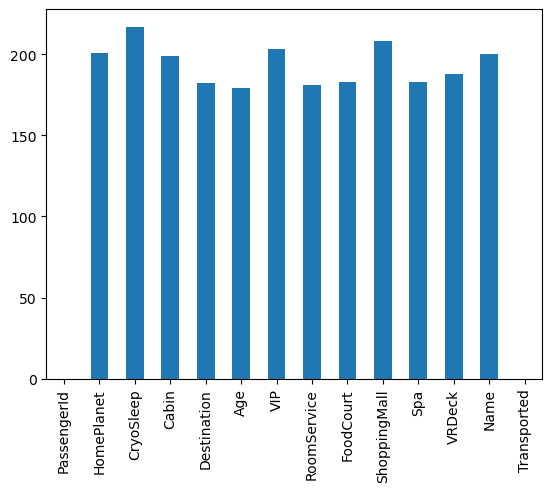

In [148]:
train.isna().sum().plot.bar()

Let's break down the names columns into first and last name

In [ ]:

amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

(
    train.assign(total=lambda x: x[amenities].sum(axis=1),
                 total_mean=lambda x: x[amenities].std(axis=1),
                 total_bin=lambda x: pd.qcut(x['total'], q=2, duplicates='drop', labels=False))
    
    .pipe(lambda df: pd.crosstab(df.Transported, df.total_bin))
    .plot.bar()
)



<Axes: >

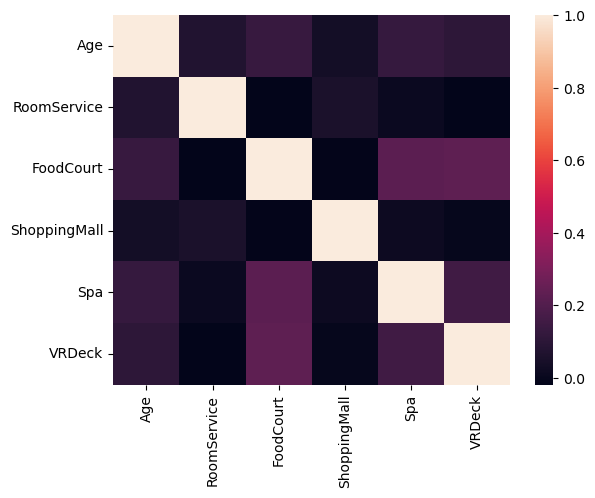

In [3]:
import seaborn as sns

sns.heatmap(train.select_dtypes(include=np.number).corr())

Let's look at the age of the passanger and if they were transported

In [ ]:


(
    train.assign(age_bin=pd.qcut(train.Age, q=10, labels=False))
    .pipe(lambda db: pd.crosstab(db.age_bin, db.Transported))
    .plot.bar()
)

In [ ]:


(
    pd.crosstab(train.CryoSleep, train.Transported).plot.bar()
)

Let's see if missing values have any relationship to transported

In [ ]:
(
    train.assign(total_na=lambda x: x.isna().sum(axis=1))
    .groupby(["total_na", "Transported"])
    .size()
    .unstack().plot.bar(stacked=False)
)

In [ ]:


fig, ax = plt.subplots()

ax.plot(train.isna().sum())
ax.plot(train.notna().sum())


display(train.isna().sum())


In [70]:
def churn_data(df):
    
    amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

    df[['Deck', 'Num', 'Side']] = df.Cabin.str.split("/", expand=True).ffill().astype('category')
    df[amenities] = df.pipe(lambda df: df[amenities].fillna(value=0)).astype('Float32')
    a =(
        df.assign(HomePlanet=lambda x: x.HomePlanet.fillna("Earth").astype('category'),
                    CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
                    Cabin= df.Cabin.ffill().infer_objects(copy=False),
                    Destination=df.Destination.ffill().astype('category'),
                    Age=df.Age.fillna(value=train.Age.median()).astype('Float32'),
                    VIP=df.VIP.fillna(value=False).astype('category'),
                    First_name= lambda x: x.Name.str.split(" ", expand=True)[0].astype('category'),
                    Passenger_Group = lambda x: x.PassengerId.str.split("_", expand=True)[0].astype('category'),
                    Total_Spent = lambda x: x[amenities].agg(['sum'], axis=1).astype('Float32'),
                    Total_Average= lambda x: x[amenities].agg(['mean'], axis=1).astype('Float32') 
                    ).drop(columns=['Name', 'Cabin', 'First_name', 'Side'])   
        
    ).drop(['PassengerId'], axis=1)
    return a

churn_data(train)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Passenger_Group,Total_Spent,Total_Average
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,0001,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,0002,736.0,147.199997
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,0003,10383.0,2076.600098
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,0003,5176.0,1035.199951
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,0004,1091.0,218.199997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,9276,8536.0,1707.199951
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,9278,0.0,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,9279,1873.0,374.600006
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,9280,4637.0,927.400024


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier


test = pd.read_csv("./datasets/spaceship-titanic/test.csv")

train = pd.read_csv("datasets/spaceship-titanic/train.csv")
import sklearn
sklearn.set_config(transform_output="pandas")

columns = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000000), make_column_selector(dtype_include=['category'])),
    verbose_feature_names_out=False, remainder="passthrough"
)

functinos_t = make_column_transformer(
    (FunctionTransformer(churn_data), make_column_selector(dtype_include=np.generic)),
    verbose_feature_names_out=False, remainder="drop"
    
)
pipeline = make_pipeline(functinos_t)

# ids = test['PassengerId']
y = train.Transported
X = train.drop("Transported", axis=1)

def create_pipeline(estimatator):
    columns = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000000), make_column_selector(dtype_include=['category'])),
    verbose_feature_names_out=False, remainder="passthrough"
    )

    functinos_t = make_column_transformer(
        (FunctionTransformer(churn_data), make_column_selector(dtype_include=np.generic)),
        verbose_feature_names_out=False, remainder="drop"
        
    )
    pipeline = make_pipeline(functinos_t, estimatator)
    return pipeline
    


# pipeline.fit(X,y)

# from sklearn.metrics import confusion_matrix
# y_pred = pipeline.predict(test)


cats = pipeline.fit_transform(X)


categorical = cats.select_dtypes(include=['category'])

cats_list = categorical.columns.to_list()


cats.isna().sum()

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Deck               0
Num                0
Passenger_Group    0
Total_Spent        0
Total_Average      0
dtype: int64

In [24]:
def submit(estimator, test):
    ids = test.PassengerId
    y_pred = estimator.predict(test)
    submission = pd.DataFrame()
    submission['PassengerId'] = ids
    submission['Transported'] = y_pred

    submission.to_csv(f'spaceship_titanic__{type(estimator)}.csv', header=True, index=False)

Let's try a dummy classifier to compare results

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change i

The accuracy is 0.5036236051995858


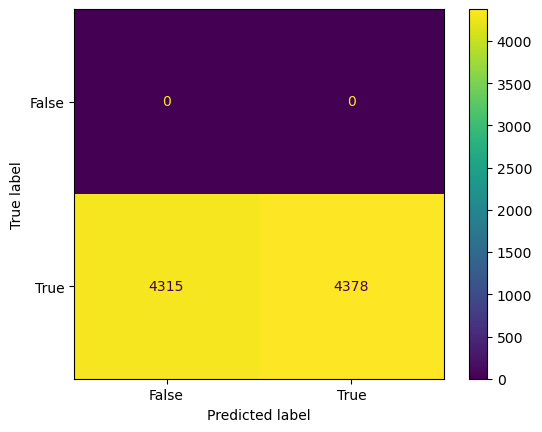

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_pipeline = make_pipeline(pipeline, dummy_clf)

dummy_pipeline.fit(X,y)

dummy_pred = dummy_clf.predict(X)

from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, accuracy_score

from sklearn.utils.validation import check_is_fitted

def score_titanic(estimator, X, y):
    try:
        check_is_fitted(estimator)
    except:
        estimator.fit(X,y)
    pred = estimator.predict(X)
    ConfusionMatrixDisplay.from_predictions(pred, y)
    print(f'The accuracy is {accuracy_score(pred, y)}')
    
score_titanic(dummy_pipeline, X,y)

In [53]:

hist = HistGradientBoostingClassifier(categorical_features="from_dtype")
hist_pipeline = create_pipeline(hist)

score_titanic(hist_pipeline,X,y)


/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/4030323270.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/4030323270.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


ValueError: Categorical feature 'Num' is expected to have a cardinality <= 255 but actually has a cardinality of 1817.

Gridsearch Time

In [15]:

parameters = {
    'max_iter': [100],
    'learning_rate': [0.1],
    'max_depth' : [None],
    'l2_regularization': [0, 1.5],
    'scoring': ['accuracy'],
    'random_state' : [42],
 }


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(HistGradientBoostingClassifier(categorical_features="from_dtype"), parameters, cv=3, 
                    scoring="accuracy",
                    refit=True)

gs_pipeline = make_pipeline(pipeline, grid)

# score_titanic(gs_pipeline,X,y)

In [54]:
play = functinos_t.fit_transform(X)

play

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,First_name,Last_name,Passenger_Group,Passenger_Id
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy,0001,01
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines,0002,01
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent,0003,01
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent,0003,02
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines,0004,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther,9276,01
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley,9278,01
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon,9279,01
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre,9280,01


In [17]:
agg = play.groupby(['Deck', 'Side'])['Age'].agg([np.mean]).reset_index()

agg

play.merge(agg, on=['Deck', 'Side'], validate="m:1")


/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/593050430.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = play.groupby(['Deck', 'Side'])['Age'].agg([np.mean]).reset_index()
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/593050430.py:1: FutureWarning: The provided callable <function mean at 0x107ad5a80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg = play.groupby(['Deck', 'Side'])['Age'].agg([np.mean]).reset_index()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,First_name,Last_name,Passenger_Group,Passenger_Id,mean
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy,0001,01,33.173687
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines,0002,01,28.55829
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent,0003,01,34.658157
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent,0003,02,34.658157
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines,0004,01,28.55829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8489,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther,9276,01,35.273228
8490,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley,9278,01,23.787468
8491,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon,9279,01,23.787468
8492,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre,9280,01,30.423443


Let's look at the size of the family and if they were transported

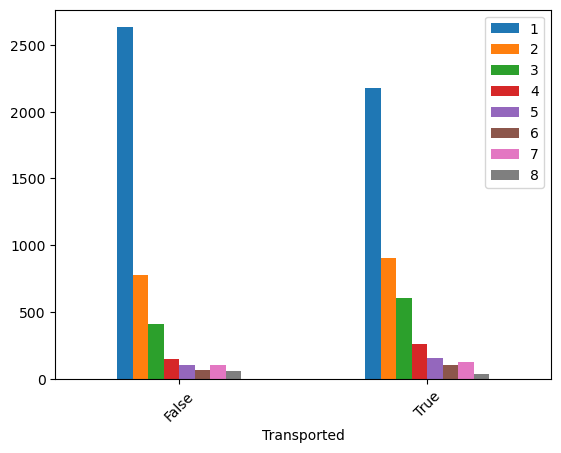

In [56]:
play["Transported"] = y 

agg2 = play.groupby(["Passenger_Group"]).size()

abcd = pd.DataFrame(agg2, columns=["Passenger_Group_Count"])
# agg2.columns = [f"last_name {x}"
#                 for x in agg2.columns.values]

play2 = play.merge(abcd, on=["Passenger_Group"], validate="m:1")



play2.groupby(["Transported", "Passenger_Group_Count"]).size().unstack().plot.bar(rot=45).legend(bbox_to_anchor=(1,1))


In [119]:

def chance_of_getting_transported(df):
    # print(df.loc[df.Transported].Transported.count())
    # print(df.Transported.size)
    # print(((df.loc[df.Transported].Transported.count()) / df.Transported.size))
    # print("===========")
    df['Percent_Transported'] = ((df.loc[df.Transported].Transported.count()) / df.Transported.size)
    return df

a = (
    play.groupby(["Passenger_Group"]).apply(chance_of_getting_transported).reset_index(drop=True)
)

a

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,First_name,Last_name,Passenger_Group,Passenger_Id,Transported,Percent_Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy,0001,01,False,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines,0002,01,True,1.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent,0003,01,False,0.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent,0003,02,False,0.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines,0004,01,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther,9276,01,False,0.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley,9278,01,False,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon,9279,01,True,1.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre,9280,01,False,0.5


Fromm printing the learning curves here, you can see that we are OVERFITTING THE DATA!

<Axes: xlabel='Transported,perf'>

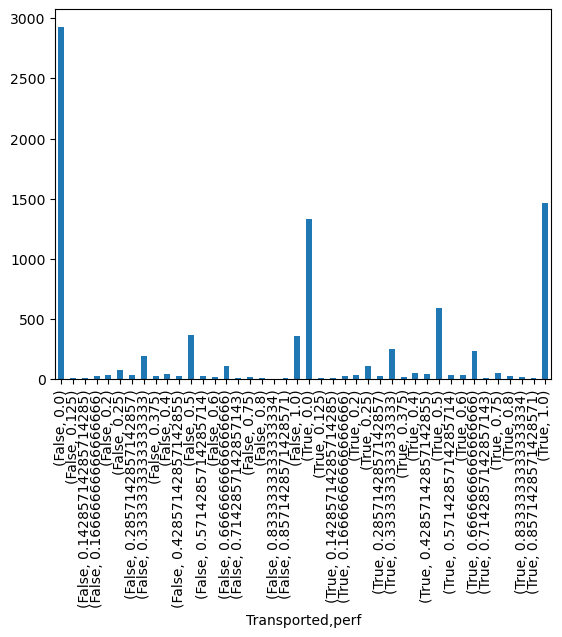

In [147]:
def perf(df):
    df['perf'] = df.loc[df.CryoSleep].CryoSleep.count() / df.CryoSleep.count()
    return df

b =(
    play.groupby(['Passenger_Group']).apply(perf)
)
b.groupby(['Transported', 'perf']).size().plot.bar()


/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),
[19:35:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "ranom_state" } are n

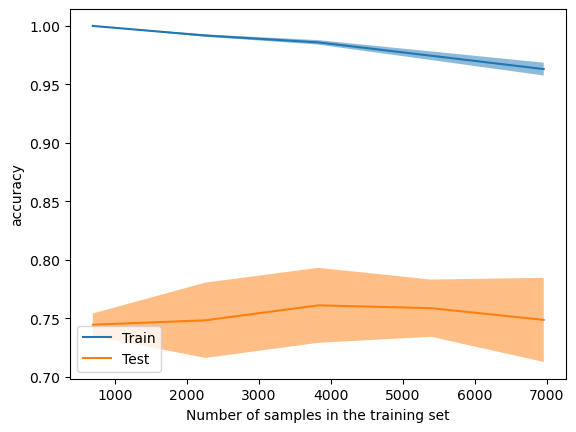

In [17]:
import xgboost as xg

xgb = xg.XGBClassifier(ranom_state=42)

boost = make_pipeline(pipeline, xgb)

#score_titanic(boost, X,y)


from sklearn.model_selection import learning_curve, LearningCurveDisplay


def print_learning_curve(estimator, X,y):
    size, train, test = learning_curve(estimator, X,y, scoring='accuracy')
    
    display = LearningCurveDisplay(train_scores=train, train_sizes=size, test_scores=test, score_name='accuracy')
    
    display.plot()
    

print_learning_curve(boost, X,y)


hist = HistGradientBoostingClassifier(categorical_features="from_dtype")
hist_pipeline2 = make_pipeline(pipeline, hist)



# print_learning_curve(hist_pipeline2, X,y)

In [20]:

import xgboost as xg

xgb = xg.XGBClassifier(ranom_state=42, n_jobs=-1)

params = {
    'estimator__max_depth': [1,2,3,4],
    'estimator__gamma': np.linspace(0.0001, .12, 5),
    'estimator__max_deplta_stop': list(range(1,6))
    
}

rb = RandomizedSearchCV(xgb, params)

boost = make_pipeline(pipeline, rb)

# print_learning_curve(boost, X,y)


In [21]:
boost[-1].get_params()

{'cv': None,
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__multi_strategy': None,
 'estima

In [22]:
play2

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,First_name,Last_name,Passenger_Group,Passenger_Id,Transported,Passenger_Group_Count
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy,0001,01,False,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines,0002,01,True,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent,0003,01,False,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent,0003,02,False,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines,0004,01,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther,9276,01,False,1
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley,9278,01,False,1
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon,9279,01,True,1
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre,9280,01,False,2


In [23]:
play

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,First_name,Last_name,Passenger_Group,Passenger_Id,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,Maham,Ofracculy,0001,01,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,Juanna,Vines,0002,01,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,Altark,Susent,0003,01,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,Solam,Susent,0003,02,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,Willy,Santantines,0004,01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,Gravior,Noxnuther,9276,01,False
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,Kurta,Mondalley,9278,01,False
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,Fayey,Connon,9279,01,True
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,Celeon,Hontichre,9280,01,False


In [24]:
play = play.assign(family_size=play.groupby('Last_name').Age.transform('size'))


/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/2345894847.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  play = play.assign(family_size=play.groupby('Last_name').Age.transform('size'))


In [25]:

play3 = play.assign(total_spent=lambda x: x.RoomService + x.FoodCourt + x.ShoppingMall + x.Spa + x.VRDeck,
            spent_per_family=lambda x: x.groupby('Last_name').total_spent.transform('mean'),
            family_size = lambda x: x.groupby(['VIP', 'Last_name']).Age.transform('size'), 
            testing_money =lambda x: pd.qcut(x.total_spent, 4, duplicates='drop', labels=False))

(
    play3.groupby(['family_size'], axis='columns').size()
)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/316155519.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spent_per_family=lambda x: x.groupby('Last_name').total_spent.transform('mean'),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/316155519.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  family_size = lambda x: x.groupby(['VIP', 'Last_name']).Age.transform('size'),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/316155519.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  play3.groupby(

Series([], dtype: int64)

In [26]:
# import lightgbm as lgb
# lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1, max_depth=1, num_leaves=4, min_child_samples=100, n_estimators=10, silent=False, verb)


# boost = make_pipeline(pipeline, lgbm)


# score_titanic(boost,X,y)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/1804326583.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_1546/1804326583.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


[LightGBM] [Warning] Unknown parameter: silent


#Let's try cat boost

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a

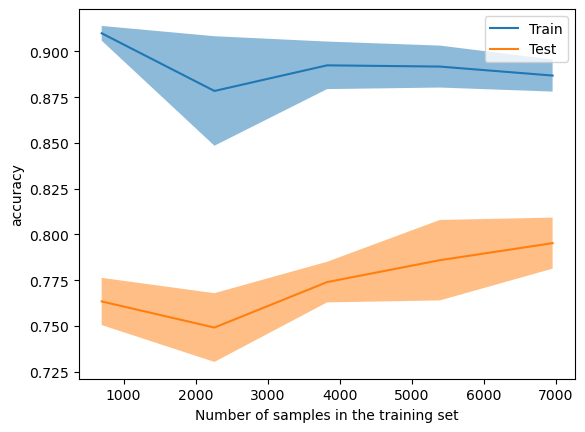

In [73]:
import catboost


cat = create_pipeline(catboost.CatBoostClassifier(verbose=False, learning_rate=.05, cat_features=cats_list))

cat.fit(X,y)

print_learning_curve(cat,X,y)

In [74]:
#score_titanic(cat, X,y)

submit(cat, test)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


In [72]:
from sklearn.ensemble import RandomForestClassifier


gs = GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': range(5,10,1)})

rfc = create_pipeline(gs)


score_titanic(rfc,X,y)

print_learning_curve(rfc,X,y)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/159797788.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2257610184.py", line 15, in score_titanic
    check_is_fitted(estimator)
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1622, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/arrays/categorical.py", line 591, in astype
    new_cats = new_cats.astype(dtype=dtype, copy=copy)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Earth'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/generic.py", line 6640, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/dtypes/astype.py", line 179, in astype_array
    values = values.astype(dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alexander.norton/Documents/Machine-Learning/.conda/lib/python3.11/site-packages/pandas/core/arrays/categorical.py", line 602, in astype
    raise ValueError(msg)
ValueError: Cannot cast object dtype to float32


In [35]:
submit(rfc,test)

/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  CryoSleep= df.CryoSleep.fillna(False).infer_objects(copy=False),
/var/folders/cv/lyp80g3175v43k438cr6bx700000gq/T/ipykernel_56063/2674563742.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VIP=df.VIP.fillna(value=False).astype('category'),


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre
